In [29]:
import torch

from pedalboard.pedalboard import load_plugin

from src.dataset.audio_dataset import AudioDataset
from src.wrappers.dafx_wrapper import DAFXWrapper
from src.wrappers.null_dafx_wrapper import NullDAFXWrapper

from src.models.spectrogram_vae import SpectrogramVAE
from src.utils import audio_to_spectrogram
import matplotlib.pyplot as plt

In [13]:
DAFX_FILE = "/home/kieran/Level5ProjectAudioVAE/src/dafx/mda.vst3"
DAFX_NAME = "mda Leslie"
SAMPLE_RATE = 24_000
AUDIO_DIR = "/home/kieran/Level5ProjectAudioVAE/src/audio"
DATASETS = ["vctk_24000"]
NUM_EXAMPLES = 10
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/src/l5proj_spectrogram_vae/21lenm4c/checkpoints/epoch=37-step=11894.ckpt"
CHECKPOINT_ID = CHECKPOINT.split("/")[-3]

In [27]:
def show_spectrogram(audio):
    if len(audio.shape) == 1:
        audio = audio.unsqueeze(0)
        audio = audio.unsqueeze(0)

    spec = audio_to_spectrogram(signal=audio)
    plt.imshow(spec.detach().squeeze(), aspect='auto')
    plt.show()

In [15]:
if DAFX_NAME.lower() == "clean":
    dafx = NullDAFXWrapper()
else:
    dafx = load_plugin(DAFX_FILE, plugin_name=DAFX_NAME)
    dafx = DAFXWrapper(dafx=dafx, sample_rate=SAMPLE_RATE)

In [16]:
dataset = AudioDataset(
    dafx=dafx,
    audio_dir=AUDIO_DIR,
    subset="train",
    input_dirs=DATASETS,
    num_examples_per_epoch=NUM_EXAMPLES,
    augmentations={},
    length=131_072,
    effect_audio=True,
    dummy_setting=True
)

loader= torch.utils.data.DataLoader(
    dataset,
    num_workers=4,
    batch_size=1,
    timeout=6000,
)

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 36317.89it/s]


Loaded 88 files for train = 66.89 hours.


In [17]:
model = SpectrogramVAE.load_from_checkpoint(CHECKPOINT)
model.eval()

SpectrogramVAE(
  (encoder_conv): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (mu): Linear(in_features=20640, out_features=32, bias=True)
  (log_var): Linear(in_features=20640, o

In [19]:
batch = next(iter(loader))
x = batch

In [20]:
from IPython.display import Audio

In [21]:
x.shape

torch.Size([1, 1, 131072])

In [22]:
Audio(x.numpy().squeeze(), rate=SAMPLE_RATE)

In [33]:


X = audio_to_spectrogram(signal=x)
# y_s = audio_to_spectrogram(signal=y)

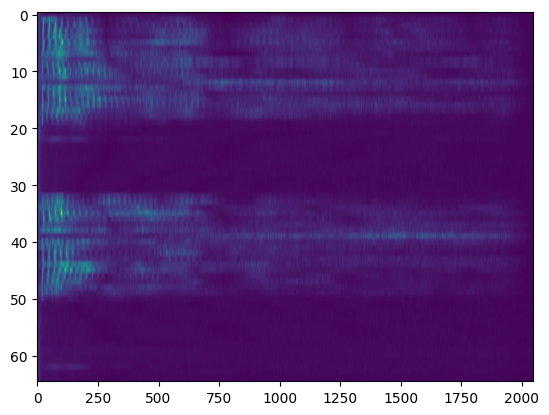

In [34]:
show_spectrogram(x)

In [35]:
X_hat, _, _, z = model(x_s)

In [36]:
X_hat.shape

torch.Size([1, 1, 65, 2049])

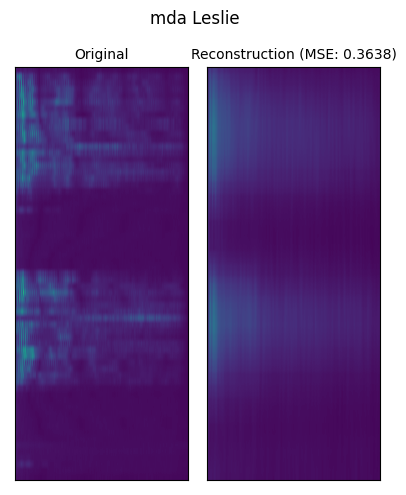

In [42]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(4,5))

# find minimum of minima & maximum of maxima
minmin = min([torch.min(X).item(), torch.min(X_hat).item()])
maxmax = max([torch.max(X).item(), torch.max(X_hat).item()])

# for each dimension
mse = F.mse_loss(X[0,0,:,:], X_hat[0,0,:,:])

ax1 = axes[0].imshow(X[0,0,:,:].detach().squeeze().numpy(),
                        aspect='auto',
                        vmin=minmin,
                        vmax=maxmax
                        )

ax2 = axes[1].imshow(X_hat[0,0,:,:].detach().squeeze().numpy(),
                        aspect='auto',
                        vmin=minmin,
                        vmax=maxmax
                        )

axes[0].set_title(f"Original", fontsize=10)
axes[1].set_title(f"Reconstruction (MSE: {mse.item():.4f})", fontsize=10)

axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_xticks([])
axes[1].set_yticks([])


# plt.savefig("./figures/spectrogram_reconstruction_lo_kld.png")

# add space for colour bar
fig.subplots_adjust(right=0.85)
# cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
# fig.colorbar(ax2, cax=cbar_ax)
fig.suptitle(DAFX_NAME)

plt.tight_layout()
plt.savefig(f"./figures/reconstructions/{CHECKPOINT_ID}_{DAFX_NAME.split()[-1].lower()}_joint_reconstruction.png")